In [1]:
import time

In [2]:
import numpy as np
import scipy as sp
import multiprocessing
import tqdm
from warnings import warn
from sklearn.utils.fixes import euler_gamma

from scipy.sparse import issparse

import numbers
import six
from sklearn.tree import ExtraTreeRegressor
from sklearn.utils import check_random_state, check_array
from sklearn.ensemble.bagging import BaseBagging

#__all__ = ["IsolationForest"]

INTEGER_TYPES = (numbers.Integral, np.integer)

In [3]:
import seaborn as sns

from matplotlib import pyplot as plt

%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

In [4]:
class Timer:
    def __init__(self, msg='operation', verbose=True):
        self.msg = msg
        self.verbose = verbose       
    def __enter__(self, ):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        if self.verbose:
            print('{} took {:.3f}s'.format(self.msg, self.interval), flush=True)

In [5]:
import ctypes

def shared_array(shape):
    """
    Form a shared memory numpy array.
    
    http://stackoverflow.com/questions/5549190/is-shared-readonly-data-copied-to-different-processes-for-python-multiprocessing 
    """
    
    shared_array_base = multiprocessing.Array(ctypes.c_double, shape[0]*shape[1])
    shared_array = np.ctypeslib.as_array(shared_array_base.get_obj())
    shared_array = shared_array.reshape(*shape)
    return shared_array

In [6]:
xtrain = np.load('xtrain.npy')
xtest = np.load('xtest.npy')
ytrain = np.load('ytrain.npy')
ytest = np.load('ytest.npy')

In [18]:
class IsolationForest(BaseBagging):
    """Isolation Forest Algorithm
    Return the anomaly score of each sample using the IsolationForest algorithm
    The IsolationForest 'isolates' observations by randomly selecting a feature
    and then randomly selecting a split value between the maximum and minimum
    values of the selected feature.
    Since recursive partitioning can be represented by a tree structure, the
    number of splittings required to isolate a sample is equivalent to the path
    length from the root node to the terminating node.
    This path length, averaged over a forest of such random trees, is a
    measure of normality and our decision function.
    Random partitioning produces noticeably shorter paths for anomalies.
    Hence, when a forest of random trees collectively produce shorter path
    lengths for particular samples, they are highly likely to be anomalies.
    Read more in the :ref:`User Guide <isolation_forest>`.
    .. versionadded:: 0.18
    Parameters
    ----------
    n_estimators : int, optional (default=100)
        The number of base estimators in the ensemble.
    max_samples : int or float, optional (default="auto")
        The number of samples to draw from X to train each base estimator.
            - If int, then draw `max_samples` samples.
            - If float, then draw `max_samples * X.shape[0]` samples.
            - If "auto", then `max_samples=min(256, n_samples)`.
        If max_samples is larger than the number of samples provided,
        all samples will be used for all trees (no sampling).
    contamination : float in (0., 0.5), optional (default=0.1)
        The amount of contamination of the data set, i.e. the proportion
        of outliers in the data set. Used when fitting to define the threshold
        on the decision function.
    max_features : int or float, optional (default=1.0)
        The number of features to draw from X to train each base estimator.
            - If int, then draw `max_features` features.
            - If float, then draw `max_features * X.shape[1]` features.
    bootstrap : boolean, optional (default=False)
        If True, individual trees are fit on random subsets of the training
        data sampled with replacement. If False, sampling without replacement
        is performed.
    n_jobs : integer, optional (default=1)
        The number of jobs to run in parallel for both `fit` and `predict`.
        If -1, then the number of jobs is set to the number of cores.
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    verbose : int, optional (default=0)
        Controls the verbosity of the tree building process.
    Attributes
    ----------
    estimators_ : list of DecisionTreeClassifier
        The collection of fitted sub-estimators.
    estimators_samples_ : list of arrays
        The subset of drawn samples (i.e., the in-bag samples) for each base
        estimator.
    max_samples_ : integer
        The actual number of samples
    References
    ----------
    .. [1] Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. "Isolation forest."
           Data Mining, 2008. ICDM'08. Eighth IEEE International Conference on.
    .. [2] Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. "Isolation-based
           anomaly detection." ACM Transactions on Knowledge Discovery from
           Data (TKDD) 6.1 (2012): 3.
    """

    def __init__(self,
                 n_estimators=100,
                 max_samples="auto",
                 contamination=0.1,
                 max_features=1.,
                 bootstrap=False,
                 n_jobs=1,
                 random_state=None,
                 verbose=0, memory_restricted=False):
        super(IsolationForest, self).__init__(
            base_estimator=ExtraTreeRegressor(
                max_features=1,
                splitter='random',
                random_state=random_state),
            # here above max_features has no links with self.max_features
            bootstrap=bootstrap,
            bootstrap_features=False,
            n_estimators=n_estimators,
            max_samples=max_samples,
            max_features=max_features,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose)
        self.contamination = contamination
        self.memory_restricted = memory_restricted

    def _set_oob_score(self, X, y):
        raise NotImplementedError("OOB score not supported by iforest")

    def fit(self, X, y=None, sample_weight=None):
        """Fit estimator.
        Parameters
        ----------
        X : array-like or sparse matrix, shape (n_samples, n_features)
            The input samples. Use ``dtype=np.float32`` for maximum
            efficiency. Sparse matrices are also supported, use sparse
            ``csc_matrix`` for maximum efficiency.
        sample_weight : array-like, shape = [n_samples] or None
            Sample weights. If None, then samples are equally weighted.
        Returns
        -------
        self : object
            Returns self.
        """
        X = check_array(X, accept_sparse=['csc'])
        if issparse(X):
            # Pre-sort indices to avoid that each individual tree of the
            # ensemble sorts the indices.
            X.sort_indices()

        rnd = check_random_state(self.random_state)
        y = rnd.uniform(size=X.shape[0])

        # ensure that max_sample is in [1, n_samples]:
        n_samples = X.shape[0]

        if isinstance(self.max_samples, six.string_types):
            if self.max_samples == 'auto':
                max_samples = min(256, n_samples)
            else:
                raise ValueError('max_samples (%s) is not supported.'
                                 'Valid choices are: "auto", int or'
                                 'float' % self.max_samples)

        elif isinstance(self.max_samples, INTEGER_TYPES):
            if self.max_samples > n_samples:
                warn("max_samples (%s) is greater than the "
                     "total number of samples (%s). max_samples "
                     "will be set to n_samples for estimation."
                     % (self.max_samples, n_samples))
                max_samples = n_samples
            else:
                max_samples = self.max_samples
        else:  # float
            if not (0. < self.max_samples <= 1.):
                raise ValueError("max_samples must be in (0, 1], got %r"
                                 % self.max_samples)
            max_samples = int(self.max_samples * X.shape[0])

        self.max_samples_ = max_samples
        max_depth = int(np.ceil(np.log2(max(max_samples, 2))))
        super(IsolationForest, self)._fit(X, y, max_samples,
                                          max_depth=max_depth,
                                          sample_weight=sample_weight)

        self.threshold_ = -sp.stats.scoreatpercentile(
            -self.decision_function(X), 100. * (1. - self.contamination))

        return self

    def predict(self, X):
        """Predict if a particular sample is an outlier or not.
        Parameters
        ----------
        X : array-like or sparse matrix, shape (n_samples, n_features)
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.
        Returns
        -------
        is_inlier : array, shape (n_samples,)
            For each observations, tells whether or not (+1 or -1) it should
            be considered as an inlier according to the fitted model.
        """
        X = check_array(X, accept_sparse='csr')
        is_inlier = np.ones(X.shape[0], dtype=int)
        is_inlier[self.decision_function(X) <= self.threshold_] = -1
        return is_inlier
    
    def _decision_function_sequential(self, X):
        n_samples = X.shape[0]
        
        if self._max_features == X.shape[1]:
            subsample_features = False
        else:
            subsample_features = True
        
        n_samples_leaf = np.zeros(n_samples)
        depths = np.zeros(n_samples)
        depths -= self.n_estimators
        
        # sequential process of estimator outputs
        for i, (tree, features) in enumerate(zip(self.estimators_,
                                                 self.estimators_features_)):
            if subsample_features:
                X_subset = X[:, features]
            else:
                X_subset = X
            leaves_index = tree.apply(X_subset)
            node_indicator = tree.decision_path(X_subset)
            n_samples_leaf = tree.tree_.n_node_samples[leaves_index]
            depths += np.ravel(node_indicator.sum(axis=1))
            depths += _average_path_length(n_samples_leaf)
        scores = 2 ** ((-depths / self.n_estimators) / _average_path_length(self.max_samples))
        return scores
    
    def _decision_function_shared_memory(self, X):
        n_samples = X.shape[0]
        
        if self._max_features == X.shape[1]:
            subsample_features = False
        else:
            subsample_features = True
        
        n_samples_leaf = np.zeros(n_samples)
        depths = np.zeros(n_samples)
        depths -= self.n_estimators        

        job_batch_size = self.n_estimators // n_jobs + (1 if self.n_estimators % n_jobs != 0 else 0)
        processes = []
        X_shared = multiprocessing.Array(ctypes.c_double if X.dtype in ['int64', 'float64'] else ctypes.c_float, X.shape[0] * X.shape[1], lock=False)
        X_shared_arr = np.ctypeslib.as_array(X_shared).reshape(X.shape)
        X_shared_arr[...] = X
        depths_lock = multiprocessing.Lock()
        depths_shared = multiprocessing.Array(ctypes.c_double, n_samples, lock=depths_lock)
        #print(type(depths_shared))
        #depths_lock = depths_shared.get_lock()
        for batch_idx in range(n_jobs):
            batch_start, batch_end = batch_idx * job_batch_size, min(self.n_estimators, (batch_idx + 1) * job_batch_size)
            p = multiprocessing.Process(target=depths_estimator,
                                        args=(self.estimators_[batch_start:batch_end],
                                              self.estimators_features_[batch_start:batch_end],
                                              X_shared_arr,
                                              depths_shared,
                                              subsample_features, batch_idx))
            processes.append(p)
        #print(len(processes))
        for p in processes:
            p.start()
        for p in processes:
            p.join()
        #print(np.ctypeslib.as_array(depths_shared.get_obj()))
        depths += np.ctypeslib.as_array(depths_shared.get_obj())
        
        scores = 2 ** ((-depths / self.n_estimators) / _average_path_length(self.max_samples))
        return 0.5 - scores
    
    def _decision_function_fast(self, X):
        n_samples = X.shape[0]
        
        if self._max_features == X.shape[1]:
            subsample_features = False
        else:
            subsample_features = True
        
        n_samples_leaf = np.zeros(n_samples)
        depths = np.zeros(n_samples)
        depths -= self.n_estimators
        
        n_jobs = multiprocessing.cpu_count() if self.n_jobs == -1 else self.n_jobs
        
        job_batch_size = self.n_estimators // n_jobs + (1 if self.n_estimators % n_jobs != 0 else 0)
        processes = []
        X_shared = multiprocessing.Array(ctypes.c_double if X.dtype in ['int64', 'float64'] else ctypes.c_float, X.shape[0] * X.shape[1], lock=False)
        X_shared_arr = np.ctypeslib.as_array(X_shared).reshape(X.shape)
        X_shared_arr[...] = X
        
        with multiprocessing.Pool(processes=n_jobs) as pool:
            estimators = []
            estimators_features = []
            for batch_idx in range(n_jobs):
                batch_start, batch_end = batch_idx * job_batch_size, min(self.n_estimators, (batch_idx + 1) * job_batch_size)
                estimators.append(self.estimators_[batch_start:batch_end])
                estimators_features.append(self.estimators_features_[batch_start:batch_end])
            depths_to_merge = list(
                pool.map(depths_estimator_local,
                         list(zip(estimators, estimators_features, [X_shared_arr] * n_jobs, [subsample_features] * n_jobs)))
            )
        for depth_to_merge in depths_to_merge:
            depths += depth_to_merge
            del depth_to_merge
        del depths_to_merge
            
        scores = 2 ** ((-depths / self.n_estimators) / _average_path_length(self.max_samples))
        return 0.5 - scores
        

    def decision_function(self, X):
        """Average anomaly score of X of the base classifiers.
        The anomaly score of an input sample is computed as
        the mean anomaly score of the trees in the forest.
        The measure of normality of an observation given a tree is the depth
        of the leaf containing this observation, which is equivalent to
        the number of splittings required to isolate this point. In case of
        several observations n_left in the leaf, the average path length of
        a n_left samples isolation tree is added.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        Returns
        -------
        scores : array of shape (n_samples,)
            The anomaly score of the input samples.
            The lower, the more abnormal.
        """
        # code structure from ForestClassifier/predict_proba
        # Check data
        X = check_array(X, accept_sparse='csr')
        n_jobs = multiprocessing.cpu_count() if self.n_jobs == -1 else self.n_jobs
        if n_jobs == 1:
            return self._decision_function_sequential(X)
        elif self.memory_restricted:
            return self._decision_function_shared_memory(X)
        else:
            return self._decision_function_fast(X)

        
        n_samples = X.shape[0]
        
        n_samples_leaf = np.zeros(n_samples)
        depths = np.zeros(n_samples)
        depths -= self.n_estimators
        
        n_jobs = multiprocessing.cpu_count() if self.n_jobs == -1 else self.n_jobs
        
        #depths_buf = np.zeros(n_samples)
        
        if self._max_features == X.shape[1]:
            subsample_features = False
        else:
            subsample_features = True

        if n_jobs == 1:
            # sequential process of estimator outputs
            for i, (tree, features) in enumerate(zip(self.estimators_,
                                                     self.estimators_features_)):
                if subsample_features:
                    X_subset = X[:, features]
                else:
                    X_subset = X
                leaves_index = tree.apply(X_subset)
                node_indicator = tree.decision_path(X_subset)
                n_samples_leaf = tree.tree_.n_node_samples[leaves_index]
                depths += np.ravel(node_indicator.sum(axis=1))
                depths += _average_path_length(n_samples_leaf)
        else:
            job_batch_size = self.n_estimators // n_jobs + (1 if self.n_estimators % n_jobs != 0 else 0)
            processes = []
            X_shared = multiprocessing.Array(ctypes.c_double if X.dtype in ['int64', 'float64'] else ctypes.c_float, X.shape[0] * X.shape[1], lock=False)
            X_shared_arr = np.ctypeslib.as_array(X_shared).reshape(X.shape)
            X_shared_arr[...] = X
            depths_lock = multiprocessing.Lock()
            depths_shared = multiprocessing.Array(ctypes.c_double, n_samples, lock=depths_lock)
            #print(type(depths_shared))
            #depths_lock = depths_shared.get_lock()
            for batch_idx in range(n_jobs):
                batch_start, batch_end = batch_idx * job_batch_size, min(self.n_estimators, (batch_idx + 1) * job_batch_size)
                p = multiprocessing.Process(target=depths_estimator,
                                            args=(self.estimators_[batch_start:batch_end],
                                                  self.estimators_features_[batch_start:batch_end],
                                                  X_shared_arr,
                                                  depths_shared,
                                                  subsample_features))
                processes.append(p)
            #print(len(processes))
            for p in processes:
                p.start()
            for p in processes:
                p.join()
            #print(np.ctypeslib.as_array(depths_shared.get_obj()))
            depths += np.ctypeslib.as_array(depths_shared.get_obj())
        scores = 2 ** ((-depths / self.n_estimators) / _average_path_length(self.max_samples))
        return 0.5 - scores

    
def depths_estimator_local(args_tuple):
    estimators_, estimators_features_, X, subsample_features = args_tuple
    if subsample_features:
        X_subset = X[:, features]
    else:
        X_subset = X
    depths = np.zeros(X.shape[0])
    
    for tree, features in zip(estimators_, estimators_features_):
        leaves_index = tree.apply(X_subset)
        node_indicator = tree.decision_path(X_subset)
        n_samples_leaf = tree.tree_.n_node_samples[leaves_index]
        avg_path_length = _average_path_length(n_samples_leaf)
        depths += np.ravel(node_indicator.sum(axis=1))
        depths += _average_path_length(n_samples_leaf)
    return depths


def depths_estimator(estimators_, estimators_features_, X, depths, subsample_features=False):
    if subsample_features:
        X_subset = X[:, features]
    else:
        X_subset = X
    
    for tree, features in zip(estimators_, estimators_features_):
        leaves_index = tree.apply(X_subset)
        node_indicator = tree.decision_path(X_subset)
        n_samples_leaf = tree.tree_.n_node_samples[leaves_index]
        avg_path_length = _average_path_length(n_samples_leaf)
        lock = depths.get_lock()
        lock.acquire()
        depths_shared_arr = np.ctypeslib.as_array(depths.get_obj())
        depths_shared_arr += np.ravel(node_indicator.sum(axis=1))
        depths_shared_arr += _average_path_length(n_samples_leaf)
        lock.release()
    return

def _average_path_length(n_samples_leaf):
    """ The average path length in a n_samples iTree, which is equal to
    the average path length of an unsuccessful BST search since the
    latter has the same structure as an isolation tree.
    Parameters
    ----------
    n_samples_leaf : array-like of shape (n_samples, n_estimators), or int.
        The number of training samples in each test sample leaf, for
        each estimators.
    Returns
    -------
    average_path_length : array, same shape as n_samples_leaf
    """
    if isinstance(n_samples_leaf, INTEGER_TYPES):
        if n_samples_leaf <= 1:
            return 1.
        else:
            return 2. * (np.log(n_samples_leaf - 1.) + euler_gamma) - 2. * (
                n_samples_leaf - 1.) / n_samples_leaf

    else:
        n_samples_leaf_shape = n_samples_leaf.shape
        n_samples_leaf = n_samples_leaf.reshape((1, -1))
        average_path_length = np.zeros(n_samples_leaf.shape)

        mask = (n_samples_leaf <= 1)
        not_mask = np.logical_not(mask)

        average_path_length[mask] = 1.
        average_path_length[not_mask] = 2. * (
            np.log(n_samples_leaf[not_mask] - 1.) + euler_gamma) - 2. * (
                n_samples_leaf[not_mask] - 1.) / n_samples_leaf[not_mask]

        return average_path_length.reshape(n_samples_leaf_shape)

In [19]:
isof = IsolationForest(n_estimators=2000, max_samples=256, random_state=rng, n_jobs=-1, verbose=1, memory_restricted=False)

In [20]:
isof.fit(xtrain[:100000])

[Parallel(n_jobs=32)]: Done   2 out of  32 | elapsed:  1.9min remaining: 28.8min
[Parallel(n_jobs=32)]: Done  32 out of  32 | elapsed:  2.0min finished


IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples=256, memory_restricted=False, n_estimators=2000,
        n_jobs=-1,
        random_state=<mtrand.RandomState object at 0x7fcd4e294f30>,
        verbose=1)

In [8]:
from sklearn.ensemble import IsolationForest as IsolationForestOriginal

In [9]:
# rng = np.random.RandomState(42)

# # Generate train data
# X = 0.3 * rng.randn(500000, 20)
# X_train = np.r_[X + 2, X - 2]
# # Generate some regular novel observations
# X = 0.3 * rng.randn(1000, 10)
# X_test = np.r_[X + 2, X - 2]
# # Generate some abnormal novel observations
# X_outliers = rng.uniform(low=-4, high=4, size=(200, 2))

In [10]:
rng = np.random.RandomState(42)
# fit the model
clf_fixed = IsolationForest(n_estimators=2000, max_samples=256, random_state=rng, n_jobs=-1, verbose=1)

In [11]:
clf_fixed.fit(xtrain)

[Parallel(n_jobs=32)]: Done   2 out of  32 | elapsed: 42.0min remaining: 630.6min
[Parallel(n_jobs=32)]: Done  32 out of  32 | elapsed: 43.6min finished


IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples=256, n_estimators=2000, n_jobs=-1,
        random_state=<mtrand.RandomState object at 0x7fcd4e294f30>,
        verbose=1)

In [12]:
train_scores = clf_fixed.decision_function(xtrain)

In [13]:
test_scores = clf_fixed.decision_function(xtest)

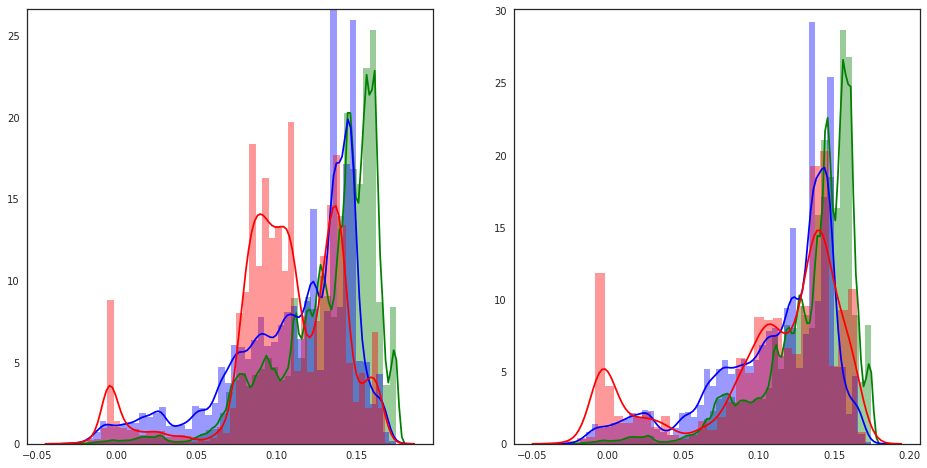

In [14]:
f, axes = plt.subplots(1, 2, figsize=(16, 8))
colors = ['g', 'b', 'r']
targets = [-1, 0, 1]
for c, t in zip(colors, targets):
    sns.distplot(train_scores[ytrain == t], color=c, ax=axes[0])

for c, t in zip(colors, targets):
    sns.distplot(test_scores[ytest == t], color=c, ax=axes[1])

In [11]:
rng = np.random.RandomState(42)

clf_orig = IsolationForestOriginal(n_estimators=200, max_samples=256, random_state=rng, n_jobs=-1, verbose=2)

In [12]:
with Timer('training orig isof'):
    clf_orig.fit(X_train)

Building estimator 1 of 7 for this parallel run (total 200)...
Building estimator 1 of 7 for this parallel run (total 200)...
Building estimator 1 of 7 for this parallel run (total 200)...
Building estimator 2 of 7 for this parallel run (total 200)...
Building estimator 1 of 7 for this parallel run (total 200)...
Building estimator 2 of 7 for this parallel run (total 200)...
Building estimator 1 of 7 for this parallel run (total 200)...
Building estimator 2 of 7 for this parallel run (total 200)...
Building estimator 1 of 7 for this parallel run (total 200)...
Building estimator 3 of 7 for this parallel run (total 200)...
Building estimator 2 of 7 for this parallel run (total 200)...
Building estimator 1 of 7 for this parallel run (total 200)...
Building estimator 3 of 7 for this parallel run (total 200)...
Building estimator 2 of 7 for this parallel run (total 200)...
Building estimator 1 of 7 for this parallel run (total 200)...
Building estimator 3 of 7 for this parallel run (total 

[Parallel(n_jobs=32)]: Done   3 out of  32 | elapsed:    7.1s remaining:  1.1min


Building estimator 2 of 6 for this parallel run (total 200)...
Building estimator 4 of 6 for this parallel run (total 200)...
Building estimator 6 of 6 for this parallel run (total 200)...
Building estimator 1 of 6 for this parallel run (total 200)...
Building estimator 7 of 7 for this parallel run (total 200)...
Building estimator 5 of 6 for this parallel run (total 200)...
Building estimator 3 of 6 for this parallel run (total 200)...
Building estimator 2 of 6 for this parallel run (total 200)...
Building estimator 4 of 6 for this parallel run (total 200)...
Building estimator 6 of 6 for this parallel run (total 200)...
Building estimator 1 of 6 for this parallel run (total 200)...
Building estimator 7 of 7 for this parallel run (total 200)...
Building estimator 5 of 6 for this parallel run (total 200)...
Building estimator 3 of 6 for this parallel run (total 200)...
Building estimator 2 of 6 for this parallel run (total 200)...
Building estimator 1 of 6 for this parallel run (total 

[Parallel(n_jobs=32)]: Done  20 out of  32 | elapsed:   12.2s remaining:    7.3s


Building estimator 4 of 6 for this parallel run (total 200)...
Building estimator 3 of 6 for this parallel run (total 200)...
Building estimator 6 of 6 for this parallel run (total 200)...
Building estimator 5 of 6 for this parallel run (total 200)...
Building estimator 4 of 6 for this parallel run (total 200)...
Building estimator 6 of 6 for this parallel run (total 200)...
Building estimator 5 of 6 for this parallel run (total 200)...
Building estimator 4 of 6 for this parallel run (total 200)...
Building estimator 6 of 6 for this parallel run (total 200)...
Building estimator 5 of 6 for this parallel run (total 200)...
Building estimator 4 of 6 for this parallel run (total 200)...
Building estimator 6 of 6 for this parallel run (total 200)...
Building estimator 5 of 6 for this parallel run (total 200)...
Building estimator 6 of 6 for this parallel run (total 200)...
Building estimator 5 of 6 for this parallel run (total 200)...
Building estimator 6 of 6 for this parallel run (total 

[Parallel(n_jobs=32)]: Done  32 out of  32 | elapsed:   15.8s finished


training orig isof took 157.030s


In [13]:
with Timer('decision fixed memory isof'):
    fixed_train_scores = clf_fixed.decision_function(X_train)

decision fixed memory isof took 2.107s


In [14]:
with Timer('decision orig isof'):
     orig_train_scores = clf_orig.decision_function(X_train)

decision orig isof took 132.605s


In [15]:
np.allclose(orig_train_scores, fixed_train_scores)

True

In [16]:
orig_train_scores[:10], fixed_train_scores[:10]

(array([0.04602475, 0.0388202 , 0.07111501, 0.0346965 , 0.07025954,
        0.04744184, 0.03835608, 0.04902568, 0.03915313, 0.06918174]),
 array([0.04602475, 0.0388202 , 0.07111501, 0.0346965 , 0.07025954,
        0.04744184, 0.03835608, 0.04902568, 0.03915313, 0.06918174]))

In [29]:
# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train, batches=True, batch_size=1024)

AttributeError: 'IsolationForest' object has no attribute 'batch_decision_function'

In [25]:
clf.batch_decision_function(X_train, batch_size=1024)

array([ 0.05725375, -0.00091935,  0.06558782, ..., -0.05519934,
       -0.06187845, -0.01813396])

In [5]:
xtrain = np.load('xtrain.npy')
xtest = np.load('xtest.npy')
ytrain = np.load('ytrain.npy')
ytest = np.load('ytest.npy')

In [6]:
isof = IsolationForest(n_estimators=100, contamination = (ytrain == 1).mean(), n_jobs=4, verbose=1)

In [7]:
isof.fit(xtrain[:, -4:], batches=True, batch_size=1024)

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.8s finished


HBox(children=(IntProgress(value=0, max=2239), HTML(value='')))

Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/const.belev/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/const.belev/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/const.belev/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/const.belev/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/const.belev/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/const.belev/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/const.belev/anaconda3/lib/

KeyboardInterrupt: 

In [32]:
multiprocessing.cpu_count()

32

In [16]:
import pandas as pd

In [ ]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

In [99]:
kek = shared_array((100, 10))

In [100]:
kek[0, 0] = 1

In [13]:
arr = np.random.normal(scale=1e4, size=(1, 1_000_000))